!!! TO DO domani !!!
- scrivere come ho fatto a sistemare la gpu dal terminale (cf conversazione con claude)


Remarks
- Added initial cell to reload modules automatically 
- ~~In `FormatData` definition~~
  - ~~file paths are hardcoded -> either provide it as a fct parameter or mention in readme how names should be formatted~~
  - ~~the line `self.adata.obs = metadata_df` rewrites `self.adata.obs_names` as well!! --> I don't know if this should later be fixed?~~
- In readme
  - in `FormatData` documentation, `.x_train` and `.x_test` are said to be DataFrames but I think they're arrays
  - `.selected_genes` are explained twice (and are the same info as `.genes`)
  - in `binary_pso` documentation, `current_data` is said to be a dataframe, but I think it is a `FormatData` object
- PredAnnModel didn't use to scale data??? <- check this!! TODO
- !!! I think results aren't deterministic/reproducible!

# Single Cell Walkthrough

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
from PAGEpy import plot_functions
from PAGEpy import pso as pso
from PAGEpy.dataset_class import GeneExpressionDataset
from PAGEpy.models import AdvancedNN, SimpleNN, TrainingConfig
import pickle
import pandas as pd
from PAGEpy import utils

# memory growth is enabled for for the gpu
gpu_available = utils.init_cuda()

2025-08-14 13:13:45.931131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755177225.945284    2450 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755177225.949664    2450 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
13:14:00 [utils:21] GPU devices available: 1
13:14:00 [utils:26] Memory growth enabled for 1 GPU(s)
13:14:00 [utils:32] Mixed precision (float16) enabled


## Create Dataset
Dataset has 2000 gene features, selected using `HVG` (can also use differential expression analysis `Diff`; leave empty to use whole gene list given by `genes_pattern`).

In [3]:
n_hvg_input_features = 2000

# TODO: instead of file patterns, use whole filenames
current_data = GeneExpressionDataset(
    data_dir="../../HIVdata/",
    counts_pattern="*counts.mtx",
    barcodes_pattern="*barcodes.txt",
    # I think here it's possible to set already processed gene list:
    genes_pattern="*genes.txt",
    metadata_pattern="*infection_status.csv",
    gene_selection="HVG",
    pval_correction="benjamini-hochberg",
    hvg_count=n_hvg_input_features,
    features_out_filename="feature_set.pkl",
    train_samples_out_filename="train_samples.txt",
    # positive_label="Infected"
)

13:14:07 [/home/jovyan/PAGEpy/PAGEpy/dataset_class.py:117] [DEBUG] tutto ok
13:14:09 [/home/jovyan/PAGEpy/PAGEpy/dataset_class.py:119] [DEBUG] tutto ok
13:14:09 [/home/jovyan/PAGEpy/PAGEpy/dataset_class.py:121] [DEBUG] tutto ok
13:14:09 [/home/jovyan/PAGEpy/PAGEpy/dataset_class.py:123] [DEBUG] tutto ok
13:14:09 [/home/jovyan/PAGEpy/PAGEpy/dataset_class.py:125] [DEBUG] tutto ok
/home/jovyan/.local/share/hatch/env/virtual/pagepy/RRSnIvUW/pagepy/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
13:14:09 [/home/jovyan/PAGEpy/PAGEpy/dataset_class.py:132] [DEBUG] tutto ok
13:14:09 [dataset_class:145] AnnData object constructed with 5261 samples and 18116 features (genes).
13:14:09 [dataset_class:152] Counts normalized and log-transformed.
13:14:09 [dataset_class:204] Split data: 4208 training samples, 1053 test samples.
/home/jovyan/.local/share/hatch/

In [4]:
# the selected genes can be loaded from the local directory, however, they are
# also an attribte of the GeneExpressionDataset object
genes_path = "feature_set.pkl"

with open(genes_path, "rb") as f:
    current_genes = pickle.load(f)
print(f"Loaded {len(current_genes)} genes as 'current_genes'")

Loaded 2000 genes as 'current_genes'


## Initialize and train NN Model

Set NN model parameters

In [5]:
# retrieved default params used in Sean's code
config = TrainingConfig(
    report_frequency=1,
    auc_threshold=1,
    learning_rate=0.001)

training_params = {
    # 'n_epochs': 50,
    'n_epochs': 500,
    'batch_size': 64,
    'seed': 42,
}

Train NN model before PSO

In [6]:
# Initialize NN model
initial_model = AdvancedNN(
    # initial_model = SimpleNN(
    n_input_features=n_hvg_input_features,
    config=config,
)

# Train model
train_history = initial_model.train(
    x_train=current_data.x_train,
    y_train=current_data.y_train,
    x_test=current_data.x_test,
    y_test=current_data.y_test,
    **training_params,
)

/home/jovyan/.local/share/hatch/env/virtual/pagepy/RRSnIvUW/pagepy/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1755177261.524593    2450 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1755177261.526169    2450 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18211 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:41:00.0, compute capability: 8.0
13:14:22 [/home/jovyan/PAGEpy/PAGEpy/models.py:371] [DEBUG] Model created with 2000 input features
I0000 00:00:1755177262.991135    2654 service.cc:148] XLA service 0x7fd51800c1c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755177262.991156    2654 service.cc:156]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 3g.20gb, Compute Capability 8.0
I

13:16:01 [plot_functions:29] Max metrics
	Train Accuracy: 1.00 | Train AUC: 1.00 | Test Accuracy: 0.87 | Test AUC: 0.95


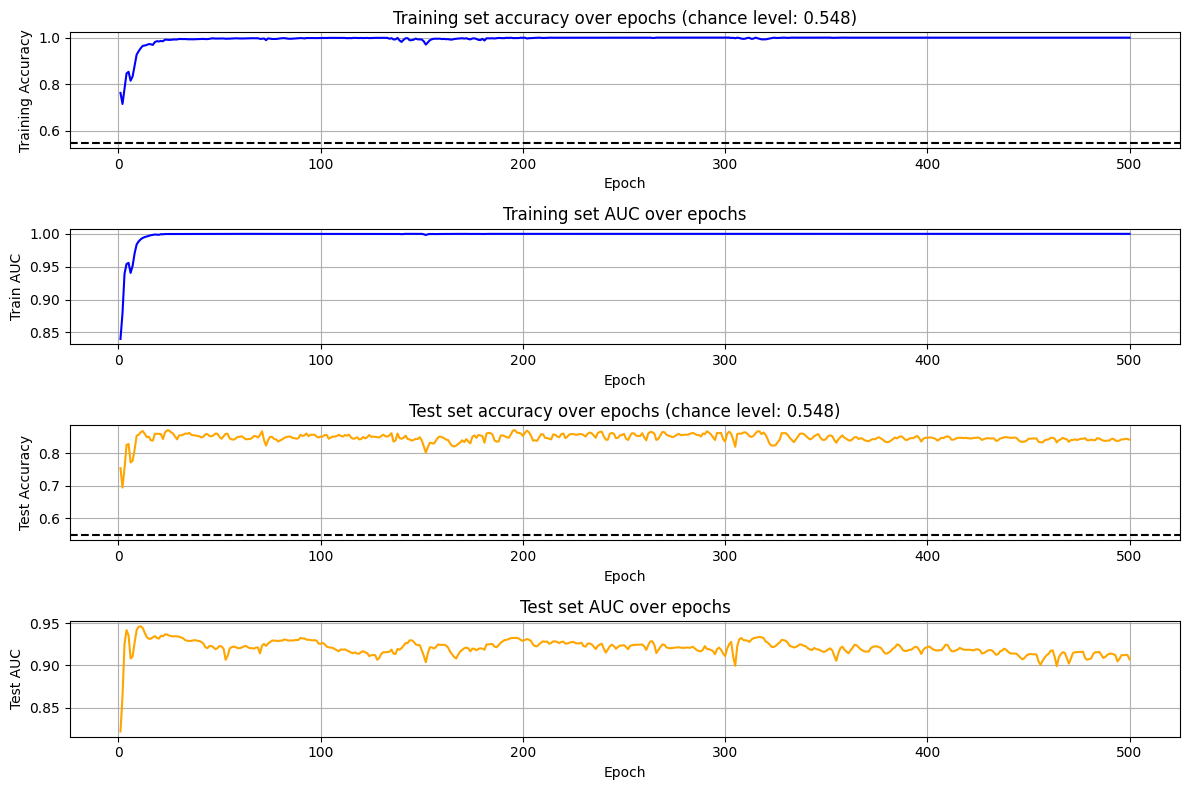

In [7]:
plot_functions.plot_model_history(
    model_history=train_history,
    report_frequency=initial_model.config.report_frequency,
    y_train=current_data.y_train,
    y_test=current_data.y_test,
    save_path=None
)

## Run binary PSO

TO DO: is the algorithm leveraging the GPU??

In [ ]:
# the pso algorithm can be use to optimze the solution
best_solution, best_fitness = pso.run_binary_pso(
    input_data=current_data,
    feature_names=current_genes,
    # pop_size=200,
    pop_size=5,
    # n_generations=15,
    n_generations=2,
    w=1,
    c1=2,
    c2=1.5,
    # n_reps=4,
    n_reps=1,
    verbose=True,
    # verbose=False,
    adaptive_metrics=False
)

In [ ]:
# the results of pso optimizatoin can be monitored
loaded_fitness_scores = pd.read_pickle("pso_fitness_scores.pkl")
loaded_particle_history = pd.read_pickle("pso_particle_history.pkl")

In [ ]:
plot_functions.plot_pso_fitness_evolution(loaded_fitness_scores)
plot_functions.plot_population_diversity(loaded_particle_history)
plot_functions.plot_feature_selection_frequency(
    loaded_particle_history)

## Initialize and train improved NN Model

In [ ]:
# the optimised solution is saved locally, however, the returned varible from
# the binary_pso function can also be passed to the model (see below)
# pso_genes = [item for item, m in zip(current_genes, best_solution) if m == 1]

# othervise just load the locally stored result file

# Load the saved genes list
with open("pso_selected_genes.pkl", "rb") as f:
    pso_genes = pickle.load(f)

In [ ]:
# now use this gene list to train a new model, which you can then evaluate
n_pso_input_features = len(pso_genes)

improved_model = AdvancedNN(
    # improved_model = SimpleNN(
    n_input_features=n_pso_input_features,
    config=config,
)

# select feature subset and scale data
x_train, x_test, y_train, y_test = current_data.get_scaled_feature_subset(
    feature_subset=pso_genes
)

# Train model
improved_train_history = improved_model.train(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    **training_params,
)

In [ ]:
plot_functions.plot_model_history(
    model_history=improved_train_history,
    report_frequency=improved_model.config.report_frequency,
    y_train=y_train,
    y_test=y_test,
    save_path=None
)